In [4]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import nolearn
from nolearn.lasagne import NeuralNet
import readdata
import lasagne
from lasagne import layers
from sklearn import metrics
import detectobjects as det
import os.path
from scipy import misc
import cv2
from progress_bar import ProgressBar
import shapefeatures
from sklearn import ensemble

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GRID K520 (CNMeM is disabled)


In [5]:
opts = {'img_dir': '../data/plasmodium-phone-verified/',
        'models_dir': '../models/',
        'annotation_dir': '../data/plasmodium-phone-verified/',
        'detection_probability_threshold': 0.5,
        'detection_overlap_threshold': 0.3, 
        'gauss': 1,
        'patch_size': (40,40),
        'image_downsample' : 2,
        'detection_step': 5,
        'patch_creation_step': 40,
        'object_class': None,
        'negative_training_discard_rate': .9
       }
opts['patch_stride_training'] = int(opts['patch_size'][0]*.25)

In [6]:
trainfiles, valfiles, testfiles = readdata.create_sets(opts['img_dir'], train_set_proportion=.5, 
                                                  test_set_proportion=.5,
                                                  val_set_proportion=0)

train_y, train_X = readdata.create_patches(trainfiles, opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])
test_y, test_X = readdata.create_patches(testfiles,  opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])

# Cut down on disproportionately large numbers of negative patches
train_X, train_y = readdata.balance(train_X, train_y, mult_neg=200)

# Create rotated and flipped versions of the positive patches
train_X, train_y = readdata.augment_positives(train_X, train_y)
test_X, test_y = readdata.augment_positives(test_X, test_y)

print '\n'
print '%d positive training examples, %d negative training examples' % (sum(train_y), len(train_y)-sum(train_y))
print '%d positive testing examples, %d negative testing examples' % (sum(test_y), len(test_y)-sum(test_y))
print '%d patches (%.1f%% positive)' % (len(train_y)+len(test_y), 100.*((sum(train_y)+sum(test_y))/(len(train_y)+len(test_y))))

[****************100%******************]  591 of 591 complete 

28544 positive training examples, 260751 negative training examples
29416 positive testing examples, 261291 negative testing examples
580002 patches (10.0% positive)


View a random selection of positive and negative patches to see if they look right

In [7]:
29416./261345

0.11255619965945397

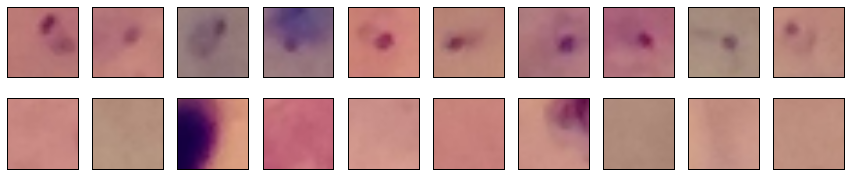

In [8]:
N_samples_to_display = 10
pos_indices = np.where(train_y)[0]
pos_indices = pos_indices[np.random.permutation(len(pos_indices))]
for i in range(N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_pos = train_X[pos_indices[i],:,:,:]
    example_pos = np.swapaxes(example_pos,0,2)
    plt.imshow(example_pos)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

neg_indices = np.where(train_y==0)[0]
neg_indices = neg_indices[np.random.permutation(len(neg_indices))]
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = train_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.gcf().set_size_inches(1.5*N_samples_to_display,3)

### CNN training

In [14]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['patch_size'][0]/opts['image_downsample'], 
                 opts['patch_size'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden3_num_units=500,
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(50).fit(train_X, train_y)

# Neural Network with 386046 learnable parameters

## Layer information

  #  name     size
---  -------  -------
  0  input    3x20x20
  1  conv1    7x18x18
  2  pool1    7x9x9
  3  conv2    12x8x8
  4  hidden3  500
  5  output   2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.18201       0.09757      1.86545      0.97166  10.04s
      2       0.07031       0.08379      0.83904      0.97592  9.94s
      3       0.05620       0.07603      0.73924      0.97853  10.01s
      4       0.04724       0.07221      0.65412      0.97848  9.96s
      5       0.04124       0.08133      0.50711      0.97639  9.88s
      6       0.03737       0.05882      0.63535      0.98241  9.91s
      7       0.03500       0.05482      0.63842      0.98356  9.92s
      8       0.03364       0.04994      0.67358      0.98467  9.97s
      9       0.03268       0.04743      0.68902      0.98543  9.94s
     1

### Make predictions and evaluate on test data

In [15]:
y_pred = cnn.predict_proba(test_X)

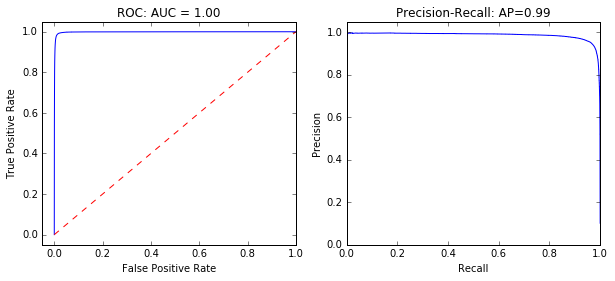

In [16]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

precision, recall, thresholds = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision = metrics.average_precision_score(test_y, y_pred[:, 1])

subplot(121)
plt.title('ROC: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(122)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

plt.gcf().set_size_inches(10,4)

#plt.savefig('figs/plasmodium-patchevaluation.png', bbox_inches='tight')

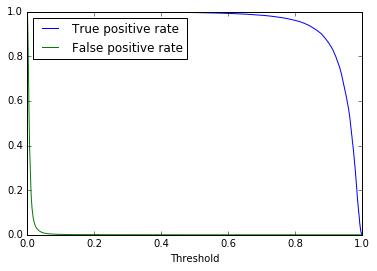

In [17]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
true_positive_rate.shape, thresholds.shape
plt.plot(true_positive_rate, thresholds,label='True positive rate')
plt.plot(false_positive_rate, thresholds, label='False positive rate')
plt.xlabel('Threshold')
plt.legend(loc='upper left')

**Examine mistakes to understand network performance: false positives.** 

Find the negative-labelled patches with highest prediction score

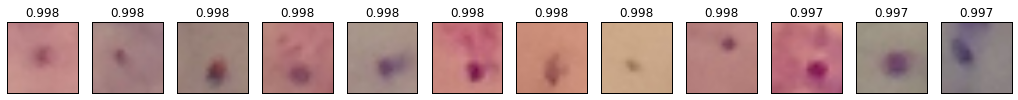

In [18]:
neg_indices = np.where(test_y==0)[0]
neg_scores = y_pred[neg_indices,1]
neg_indices = neg_indices[neg_scores.argsort()]
neg_indices = neg_indices[::-1]

neg_scores = y_pred[neg_indices,1]

N_samples_to_display = 12
offset = 55
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[neg_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % neg_scores[i+offset])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/plasmodium-falsedetections.png', bbox_inches='tight')

See highest-scored test patches

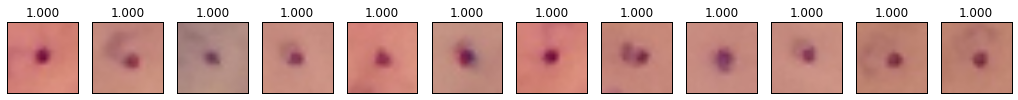

In [19]:
prob_range = [.95,1.]

tmp_scores = y_pred.copy()[:,1]
tmp_scores[tmp_scores<prob_range[0]] = -1
tmp_scores[tmp_scores>prob_range[1]] = -1

pos_indices = tmp_scores.argsort()
pos_indices = pos_indices[::-1]

N_samples_to_display = 12
offset = 0
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (tmp_scores[pos_indices[i+offset]]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/plasmodium-detectedpatches.png', bbox_inches='tight')

See lowest scored test patches

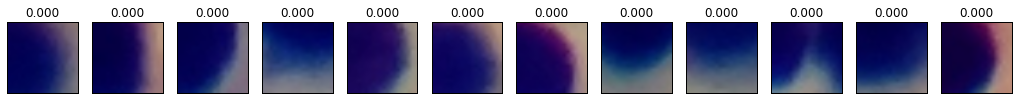

In [20]:
pos_indices = y_pred[:,1].argsort()

N_samples_to_display = 12

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (y_pred[pos_indices[i],1]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/plasmodium-testpatches-lowprob.png', bbox_inches='tight')

### Example of objects detected in an entire image

The white boxes represent annotations in the training data. Red boxes are detections by the convnet.

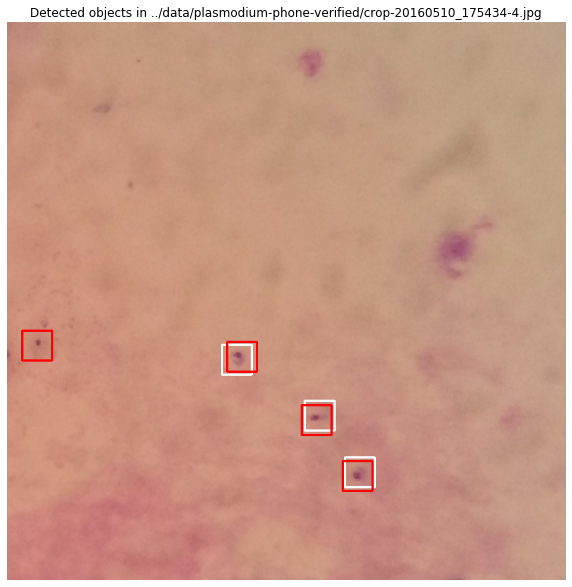

In [21]:
reload(det)

fname = testfiles[1]
imfile = opts['img_dir'] + fname
opts['detection_probability_threshold'] = 0.95

found = det.detect(imfile, cnn, opts)

im = misc.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

annofile = opts['annotation_dir'] + fname[:-3] + 'xml'
bboxes = readdata.get_bounding_boxes_for_single_image(annofile)
for bb in bboxes:
    bb = bb.astype(int)
    cv2.rectangle(im, (bb[0],bb[2]), (bb[1],bb[3]), (255,255,255), 2)  

for f in found:
    f = f.astype(int)
    cv2.rectangle(im, (f[0],f[1]), (f[2],f[3]), (255,0,0), 2)

plt.gcf().set_size_inches(10,10)
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im)

#cv2.imwrite('detectionimages/detected-' + os.path.basename(imfile),im)

### Evaluation: compare with classification based on morphological feature extraction

In [22]:
featureset = [3,7,11,12,15,17]
centiles = [0,25,50,75,100]

pb = ProgressBar(train_X.shape[0])
train_X_f = []
for i in range(train_X.shape[0]):
    if i % 100 == 0:
        pb.step(i)
    graypatch = cv2.cvtColor(np.swapaxes(train_X[i,:,:,:],0,2).astype('uint8'), cv2.COLOR_BGR2GRAY)
    train_X_f.append(shapefeatures.extract(graypatch,attributes=featureset,centiles=centiles, momentfeatures=True))
train_X_f = np.vstack(train_X_f)

test_X_f = []
for i in range(test_X.shape[0]):
    if i % 100 == 0:
        pb.step(i)
    graypatch = cv2.cvtColor(np.swapaxes(test_X[i,:,:,:],0,2).astype('uint8'), cv2.COLOR_BGR2GRAY)
    test_X_f.append(shapefeatures.extract(graypatch,attributes=featureset,centiles=centiles, momentfeatures=True))
test_X_f = np.vstack(test_X_f)

[****************100%******************]  290601 of 289295 complete


In [23]:
clf = ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
clf.fit(train_X_f, train_y)
y_pred_CLF = clf.predict_proba(test_X_f)

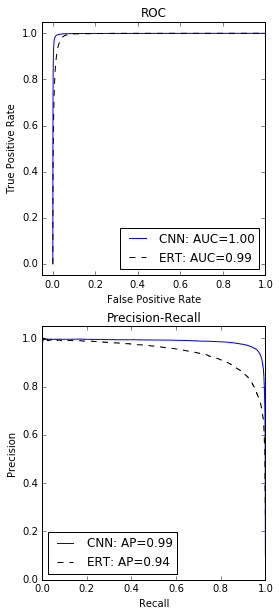

In [24]:
false_positive_rate_CNN, true_positive_rate_CNN, thresholds_CNN = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc_CNN = metrics.auc(false_positive_rate_CNN, true_positive_rate_CNN)

precision_CNN, recall_CNN, thresholds_CNN = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision_CNN = metrics.average_precision_score(test_y, y_pred[:, 1])

false_positive_rate_CLF, true_positive_rate_CLF, thresholds_CLF = metrics.roc_curve(test_y, y_pred_CLF[:,1])
roc_auc_CLF = metrics.auc(false_positive_rate_CLF, true_positive_rate_CLF)

precision_CLF, recall_CLF, thresholds_CLF = metrics.precision_recall_curve(test_y, y_pred_CLF[:,1])
average_precision_CLF = metrics.average_precision_score(test_y, y_pred_CLF[:, 1])

subplot(211)
plt.title('ROC' )
plt.plot(false_positive_rate_CNN, true_positive_rate_CNN, 'b', label='CNN: AUC=%.2f' % (roc_auc_CNN))
plt.plot(false_positive_rate_CLF, true_positive_rate_CLF, 'k--', label='ERT: AUC=%.2f' % (roc_auc_CLF))
plt.legend(loc='lower right')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(212)
plt.plot(recall_CNN, precision_CNN, label='CNN: AP=%.2f' % (average_precision_CNN))
plt.plot(recall_CLF, precision_CLF,'k--', label='ERT: AP=%.2f' % (average_precision_CLF))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")

plt.gcf().set_size_inches(4,10)

plt.savefig('figs/plasmodium-phone-patchevaluation.png', bbox_inches='tight')

In [25]:
for v in ['false_positive_rate_CNN','true_positive_rate_CNN','false_positive_rate_CLF',
 'true_positive_rate_CLF','roc_auc_CNN','roc_auc_CLF','recall_CNN','precision_CNN',
 'average_precision_CNN','recall_CLF','precision_CLF','average_precision_CLF']:
    print '"%s": %s,' % (v,v)

"false_positive_rate_CNN": false_positive_rate_CNN,
"true_positive_rate_CNN": true_positive_rate_CNN,
"false_positive_rate_CLF": false_positive_rate_CLF,
"true_positive_rate_CLF": true_positive_rate_CLF,
"roc_auc_CNN": roc_auc_CNN,
"roc_auc_CLF": roc_auc_CLF,
"recall_CNN": recall_CNN,
"precision_CNN": precision_CNN,
"average_precision_CNN": average_precision_CNN,
"recall_CLF": recall_CLF,
"precision_CLF": precision_CLF,
"average_precision_CLF": average_precision_CLF,


In [26]:
results = {
"false_positive_rate_CNN": false_positive_rate_CNN,
"true_positive_rate_CNN": true_positive_rate_CNN,
"false_positive_rate_CLF": false_positive_rate_CLF,
"true_positive_rate_CLF": true_positive_rate_CLF,
"roc_auc_CNN": roc_auc_CNN,
"roc_auc_CLF": roc_auc_CLF,
"recall_CNN": recall_CNN,
"precision_CNN": precision_CNN,
"average_precision_CNN": average_precision_CNN,
"recall_CLF": recall_CLF,
"precision_CLF": precision_CLF,
"average_precision_CLF": average_precision_CLF,
"opts": opts
}
import pickle
pickle.dump(results,open('plasmodium-phone-results.pkl','w'))